<a href="https://colab.research.google.com/github/3minuterecord/myJup/blob/master/MTG_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning GPT-2 for Magic the Gathering Card flavour text generation.
---

Magic the gathering is a trading card game with pretty illustrous lore and back stories originally created by the the [Wizards of the Coast](https://en.wikipedia.org/wiki/Wizards_of_the_Coast). Every card has unique attributes and most have individualized "Flavor Text" that relates in some way to the characters background, story or position in the world. They are usually, short, sharp and super dramatic. In this notebook we will be using [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune our own [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) to generate flavor text of our own!

![MTG](https://i.imgur.com/f1Cygtd.jpeg)

I've borrowed heavily from those who came before me for inspiration and code chunks for this notebook, please check out [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/), who in turn heavily cites [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial, [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial and the [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

By the end of this tutorial you should be able to quickly and easily fine tune your own language model for generative tasks and have a decent understanding of the levers you can adjust to parameterize the model!





# Setup

We will be fine tuning an existing GPT2 model using the interface Hugging Face provides. Fine tuning instead of retraining for a few very simple and pragmatic reasons. First among them these language models requre vast swaths of data and are computationally prohibitively expensive to train. However, by leveraging what is already available we can cut out both of these requirements. This means we can tweak the outputs of the model to suit specific purposes with minimal data and with achievable hardward. This is essentially transfer learning for language generation problems. To start off with we need to install the Huggingface transformers library first. Many of the common scientific libraries are pre-installed on Colab but not this one in particular. Installing transformers will also install tokenizers, a dependency, and another useful set of tools for this task.

In [ ]:
%%capture
!pip install transformers

# Create Training Set

We're going to use the flavor text of existing MTG cards to generate new ones. Luckily, the hard work of scraping the data has been done for us and we can ingest the flavor text from the [Scryfall](https://scryfall.com/advanced) API and quickly parson the json we are returned. 


In [ ]:
# We'll need these libraries to gather and shape the data.
import requests 
import pandas as pd
from itertools import compress

# This will return the data for all the cards available to scryfall.
r = requests.get('https://c2.scryfall.com/file/scryfall-bulk/all-cards/all-cards-20200831091816.json')
data = r.json()

# we'll start parsing by removing any cards with no flavor text
contains_x = []
for i in data:
    contains_x.append('flavor_text' in i.keys())

data_filtered = list(compress(data, contains_x))

# next we'll remove any cards in a language other than english
contains_y = []
for i in data_filtered:
  contains_y.append('lang' in i.keys() and 'en' == i['lang'])

data_filtered = list(compress(data_filtered, contains_y))

# Now we'll create a list to iterate through.
cardValues = []
for i in data_filtered:
    cardValues.append(i['flavor_text'])

# I'll convert this to a data frame to visualize a few rows nicely
# mostly just a sanity check.
df = pd.DataFrame(
    cardValues,
    columns=['data']
    )

cards = df.data.copy()

# GPT2 Tokenizer

First a brief description of tokenization straight from the source, the Hugging Face [Tokenizers](https://github.com/huggingface/tokenizers) github page:

```
What is a Tokenizer

A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

We will be using the GPT-2 tokenizer to tokenize our flavor text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but we can specifically set them differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. The next cell will instantiate our tokenizer and provide an example encoding.

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word emebedding are fine-tuned or trained.


[36674, 8255]

From the example above we can see that the example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the string, in this case one value per word. These values are easier to train the neural network model on than the string representation. We now have a corpus of flavour text we can iterate through, and a tokenizer, we should quickly inspect it to see what the longest string is, this will be useful later when we need to know how long to pad our sentences out to.


In [ ]:
max_flavour = max([len(tokenizer.encode(card)) for card in cards])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 98 tokens long.


# PyTorch Datasets & Dataloaders


Different language models require different amounts of memory to hold all of the weights and biases in memory. Based on the memory your machine has available this will determine how you set your batch size. If your instance is running on a T4 GPU you can set batch to 32, but you may have to scale down if allocated a less powerful instance. 

In [ ]:
!nvidia-smi

Fri Sep  4 14:16:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
bs = 32

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

The next thing to do is to create a custom dataloader for our corpus, we will follow the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation on this to create ```MTGDataset```.

In [ ]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class MTGDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

The maximum length of tokens is 768, however we don't need to use this length as we saw that the longest string we are encoding is only 98 words long. So to save space in the model we will only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. Next we will create the dataset itself using this class. Like I described above in the code each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask. This dataset will then be split into the training and validation sets.


In [ ]:
from torch.utils.data import random_split

dataset = MTGDataset(cards, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 26299 samples for training, and 2923 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [ ]:
dataset[0]

(tensor([50257,     1,    32, 36788,  4721,    11,   290,   674, 20507,   547,
         25891,   991,   276,    13,  1675,  1445,   373,   284,  4574,   262,
           995,    13,   887,   262,  1017,  1428,   338, 26573,   991,   665,
         10981,    11,  2266, 14129,  4120,   287,   383,    67,   338,  7721,
            11,   290, 12183, 23461,   286,  2910,  9174,   287,   262,  1633,
           526,   198,   960,  2782,   296,  4476,   292,   831,    11,  3932,
           282,   680,  4293, 50256, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 822. Loss:1.027260422706604. Time:0:01:33
Example output:  bipartisanThe sky is dark. Only life can breathe in its dark moments.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 822. Loss:0.945956289768219. Time:0:03:06
Example output:  increasing"We're trying to learn to play with each other."
—Nicol Bolas


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 822. Loss:0.829818069934845. Time:0:04:39
Example output: dayThe land is full of wildflowers, so you must carefully choose your crop. This is why the trees grow like the greys, leaping from tree to tree.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 400 of 822. Loss:0.7105399966239929. Time:0:06:11
Example output:  HangThe bane of ambition in a city filled with a dying soul.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 500 of 822. Loss:0.892336905002594. Time:0:07:42
Example output:  foods"The more we learn about the universe, the less we fear it."
—Elvish proverb


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 600 of 822. Loss:1.6840546131134033. Time:0:09:13
Example output:  trail-" a of all I as with,, as more in a to of nature in the to the., have a the best. be her- a, the the in to for


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 700 of 822. Loss:1.626314401626587. Time:0:10:45
Example output: intendIt." that have


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 800 of 822. Loss:1.6234583854675293. Time:0:12:16
Example output:  surround"'s in all, a heart of his one a battle of the soul or will the strength—
Average Training Loss: 1.3565804301387203. Epoch time: 0:12:36
Validation loss: 1.5071430595024773. Validation Time: 0:00:29
Beginning epoch 2 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 822. Loss:1.5161793231964111. Time:0:01:31
Example output:  reflex"It has that are no no of her dead."


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 822. Loss:0.7318093776702881. Time:0:03:03
Example output:  displayThe light of the kithkin peaks in the heavens with the earth as its shade.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 822. Loss:0.6611519455909729. Time:0:04:34
Example output:  pastorThe most disappointing thing about studying this project is the assumption that you never really get the answer.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 400 of 822. Loss:0.6856027245521545. Time:0:06:05
Example output:  illicit"Don't stop at nothing. Find the rest on your own time."


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 500 of 822. Loss:0.6606246829032898. Time:0:07:36
Example output:  Liberation"The earth is filled with evil. There is even worse. We must purge it of all evil so that only good humans may benefit from its dark energies."
—Halvor Arenson, Kjeldoran Royal Mage


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 600 of 822. Loss:0.7508746385574341. Time:0:09:08
Example output:  Nam"When there are no guards, it's easy to run up a mountain. When there are no obstacles, it's a good time to flee."
—Rielle Fiksdotter, Leader of the Knights of Stromgald


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 700 of 822. Loss:0.7472415566444397. Time:0:10:39
Example output: ION"We live in harmony, with our dead loved ones fed on love, and we are the foundation of this world."
—Kylo the Elder


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 800 of 822. Loss:0.6744431853294373. Time:0:12:11
Example output:  glimpse"The past is no excuse to fall prey to the ravings of the present. If we fail to heed their warnings, what is our duty?"
—Rukarumel, elder druid of the Juniper Order
Average Training Loss: 0.8532402965346683. Epoch time: 0:12:31
Validation loss: 0.6574541187804678. Validation Time: 0:00:29
Beginning epoch 3 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 822. Loss:0.6345912218093872. Time:0:01:31
Example output:  LaureWhen the thunderous low notes echo through the trees, all things benefit.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 822. Loss:0.6756399273872375. Time:0:03:03
Example output: ismA giant of a man, the giant of a woman. A monster of a woman.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 822. Loss:0.6838239431381226. Time:0:04:34
Example output: oun"The next of the dead. The living... / But death has no name."
—Ertai, wizard adept


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 400 of 822. Loss:0.6175540089607239. Time:0:06:05
Example output:  electionOnly those gifted with the Immortal Sun will see their Immortal Sun.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 500 of 822. Loss:0.5614683032035828. Time:0:07:36
Example output:  crazy"The world grows rot with rot. Let's just hope that we don't rot the whole world."


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 600 of 822. Loss:0.531876266002655. Time:0:09:08
Example output:  bench"The sea is in my blood and I am yours. Behold the beauty of the world, the way in which you lived before me."


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 700 of 822. Loss:0.49778780341148376. Time:0:10:39
Example output:  incorporatedKongming's troops never had time to waste on cavalry.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 800 of 822. Loss:0.544672429561615. Time:0:12:10
Example output: Peter"My heart was once a hundred li—"
Average Training Loss: 0.558850337409045. Epoch time: 0:12:30
Validation loss: 0.5811365421699441. Validation Time: 0:00:29
Beginning epoch 4 of 4


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 100 of 822. Loss:0.4965227544307709. Time:0:01:31
Example output: uringThe only question the mages ask is, "Will my sword blow away your skull?"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 200 of 822. Loss:0.46999651193618774. Time:0:03:02
Example output:  reproductiveWhen provoked, it launches outward to find a mate.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 300 of 822. Loss:0.4927615821361542. Time:0:04:33
Example output:  zone"Where the flesh grows strongest, the bones will do."
—Vorinclex, Voice of Hunger


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 400 of 822. Loss:0.4562358260154724. Time:0:06:04
Example output:  commits"The people of Esper measure their wealth by the number of servants they command."
—Lazav


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 500 of 822. Loss:0.448271244764328. Time:0:07:35
Example output:  ironyWhen the land is angry, so are they.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 600 of 822. Loss:0.43073570728302. Time:0:09:07
Example output:  Sah"How could it have imagined they could trade in their dreams for something else?"


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 700 of 822. Loss:0.47097498178482056. Time:0:10:38
Example output:  BryanIt's true most trees are ugly. They live in total darkness, so they make a perfect cover for the human eyes.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Batch 800 of 822. Loss:0.47759246826171875. Time:0:12:09
Example output:  spirits"Your bones will rot and rust, your flesh will rot, your mind will blacken, and your heart will shrivel."
—Dravash, Gruul shaman
Average Training Loss: 0.44866578806635815. Epoch time: 0:12:29
Validation loss: 0.5606984243444775. Validation Time: 0:00:29
Total training took 0:52:00


Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


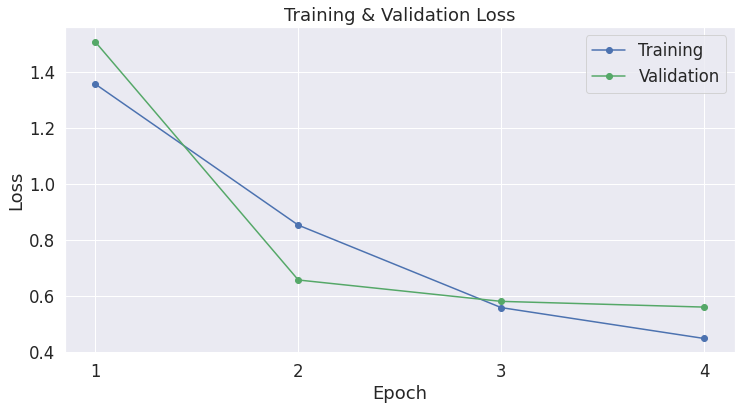

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving & Loading Fine-Tuned Model

Next it is a good idea to move the model we have trained and the associated weights, biases and model parameters out of the Colab space and into our own google drives. The cell below will mount your drive for you, then you can save the model using the prebuilt Hugging Face and PyTorch functionalities.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

output_dir = '/content/drive/My Drive/MTG'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Generate Text

Lastly the fun part! We will now generate samples from our model to test how well our model performs!

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0: He raged at the world and at his family. But mostly he just raged.


1: The more you struggle against it, the harder it adopts its hunger.


2: "There are relatively few tales of pirates. There's only one myth of a pirate landing without a weapon."
—Kadri, Captain of the Guard




If you are familiar with MTG then you can evaluate these for yourself to determine how well the model has worked, or if you have modified the code to accept your own data input for a specific task this is what you are looking to evaluate for your own uses. Lastly, if you want to load the model you have saved to your google drive, the next cell will load the fine tuned GPT2 model and tokenizer, this means you can also share your model with other!

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)